In [60]:
# import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [61]:
# ====================================================================
# PART 1: LOAD IMAGES INTO ARRAYS
# ====================================================================

DATASET_PATH = DATASET_PATH = r"D:\realwaste" # Update this path to your dataset location
IMG_HEIGHT, IMG_WIDTH = 128, 128

def load_dataset(dataset_path, img_height, img_width):
    X, y = [], []
    class_names = sorted(os.listdir(dataset_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in tqdm(os.listdir(class_dir), desc=f'Loading {class_name}'):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img) / 255.0
                X.append(img_array)
                y.append(label)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    return np.array(X), np.array(y), class_names

X, y, class_names = load_dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH)
num_classes = len(class_names)
print(f"Dataset loaded: {X.shape[0]} images, {num_classes} classes")

Loading realwaste-main: 100%|██████████| 1/1 [00:00<00:00, 314.65it/s]


Skipping D:\realwaste\realwaste-main\README.md: cannot identify image file <_io.BytesIO object at 0x00000151C79C82C0>
Dataset loaded: 4752 images, 10 classes


In [62]:
# ====================================================================
# PART 2: TRAIN-VALIDATION-TEST SPLIT (70%-15%-15%)
# ====================================================================

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 3326
Validation samples: 713
Testing samples: 713


In [ ]:
# ====================================================================
# PART 3: BUILD THE FINE-TUNED VGG16 MODEL
# ====================================================================

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Build new model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [64]:
# ====================================================================
# PART 4: TRAIN THE MODEL (20 epochs)
# ====================================================================

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=20,
    verbose=1
)


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.3614 - loss: 1.7540 - val_accuracy: 0.5077 - val_loss: 1.4156
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.5147 - loss: 1.3628 - val_accuracy: 0.5624 - val_loss: 1.2570
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.5722 - loss: 1.2363 - val_accuracy: 0.5722 - val_loss: 1.2040
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5908 - loss: 1.1485 - val_accuracy: 0.6185 - val_loss: 1.1251
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 146s 874ms/step - accuracy: 0.6167 - loss: 1.0729 - val_accuracy: 0.6143 - val_loss: 1.0912
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 156s 934ms/step - accuracy: 0.6335 - loss: 1.0214 - val_accuracy: 0.6185 - val_loss: 1.0505
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 193s 879ms/step - accuracy: 0.6633 - loss: 0.9727 - val_accuracy: 0.6522 - val_loss: 1.0206
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.6714 - loss: 0.9395 -

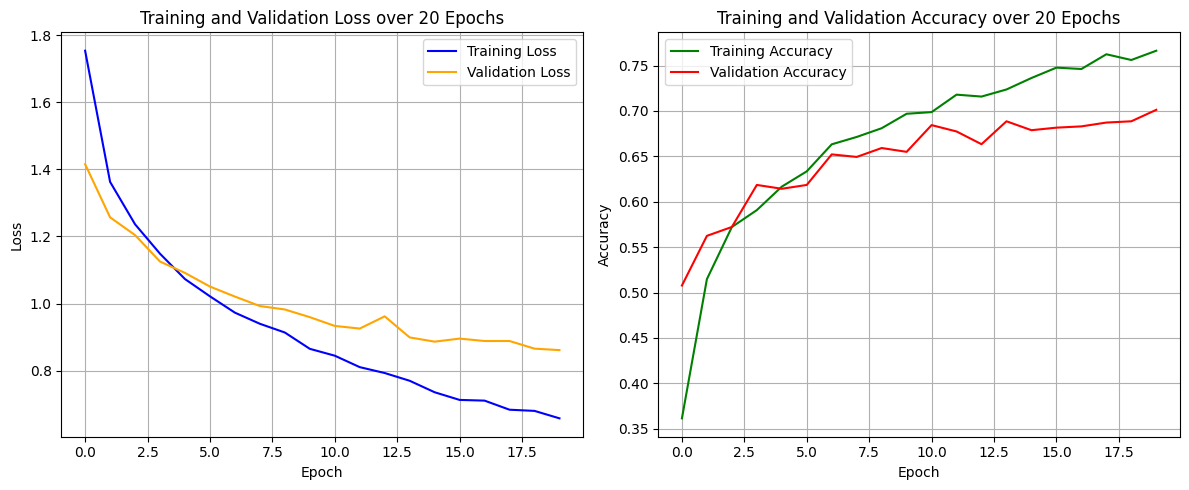

In [65]:
# ====================================================================
# PART 5: TRAINING METRICS
# ====================================================================

# Get training metrics
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(12, 5))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()
plt.show()



In [66]:
# ====================================================================
# PART 6: EVALUATION ON TEST SET
# ====================================================================

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n================ Evaluation Results ================")
print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step

================ Evaluation Results ================
Train Accuracy: 76.64%
Train Loss: 0.6574
Test Accuracy: 69.00%
Test Loss: 0.8386
Precision: 0.7050
Recall: 0.6915
F1-Score: 0.6905


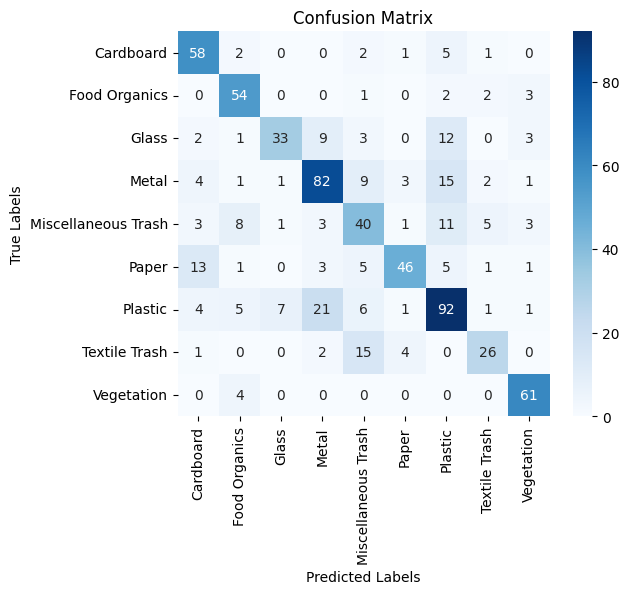


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.68      0.84      0.75        69
      Food Organics       0.71      0.87      0.78        62
              Glass       0.79      0.52      0.63        63
              Metal       0.68      0.69      0.69       118
Miscellaneous Trash       0.49      0.53      0.51        75
              Paper       0.82      0.61      0.70        75
            Plastic       0.65      0.67      0.66       138
      Textile Trash       0.68      0.54      0.60        48
         Vegetation       0.84      0.94      0.88        65

           accuracy                           0.69       713
          macro avg       0.70      0.69      0.69       713
       weighted avg       0.70      0.69      0.69       713



In [67]:
# ====================================================================
# PART 7: CONFUSION MATRIX & REPORT
# ====================================================================

# Ensure y_true and y_pred are numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Identify unique labels actually present in y_true
unique_labels = np.unique(y_true)
filtered_class_names = [class_names[i] for i in unique_labels]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_class_names))